In [1]:
# imports
import pandas as pd
import folium
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# import vacation data
vacation = pd.read_csv('./data/vacation_geo.csv')
vacation['Name'] = vacation[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(vacation.columns)
print(vacation.shape)
vacation.head()

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(47, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Highland,Denver,Colorado,USA,39.761133,-105.026392,"Highland, Denver, Colorado, USA"
1,Lodo,Denver,Colorado,USA,39.758270,-104.997257,"Lodo, Denver, Colorado, USA"
2,River North,Denver,Colorado,USA,39.768557,-104.980489,"River North, Denver, Colorado, USA"
3,Manitou Springs,Manitou Springs,Colorado,USA,38.854896,-104.898813,"Manitou Springs, Manitou Springs, Colorado, USA"
4,Downtown,Atlanta,Georgia,USA,33.759502,-84.387993,"Downtown, Atlanta, Georgia, USA"


In [3]:
# check locations
vacation[['Region','Country']].value_counts()

Region          Country
Ontario         Canada     11
Quebec          Canada      5
Georgia         USA         5
Tokyo           Japan       4
Florida         USA         4
Colorado        USA         4
California      USA         3
Tennessee       USA         2
South Carolina  USA         2
Kyoto           Japan       2
Yamanashi       Japan       1
Osaka           Japan       1
Nara            Japan       1
Louisiana       USA         1
Alabama         USA         1
dtype: int64

In [4]:
# visualize vacation locations
latitude = vacation.lat.mean()
longitude = (vacation.lon.max() + vacation.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, name in zip(vacation['lat'], 
                          vacation['lon'],
                          vacation['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [5]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
vacation_venues = getNearbyVenues(names=vacation['Name'],
                                 latitudes=vacation['lat'],
                                 longitudes=vacation['lon']
                                )
print("All done!")

All done!


In [8]:
print(vacation_venues.shape)
vacation_venues.head()

(2794, 7)


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Highland Park,39.762880,-105.026054,Park
1,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Tacos Tequila Whiskey,39.762012,-105.030019,Taco Place
2,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Orangetheory Fitness,39.762002,-105.030061,Gym
3,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Starbucks,39.760393,-105.024941,Coffee Shop
4,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Denver Bread Company,39.762274,-105.030000,Bakery


In [9]:
print('There are {} uniques categories.'.format(len(vacation_venues['Venue Category'].unique())))

There are 321 uniques categories.


Lots of coffee shops!
count            2794
unique            321
top       Coffee Shop
freq              138
Name: Venue Category, dtype: object 

Coffee Shop            138
Café                   125
Hotel                  122
Bar                     74
Japanese Restaurant     73
Italian Restaurant      55
Pizza Place             53
Restaurant              47
American Restaurant     38
Park                    37
Name: Venue Category, dtype: int64 

Coffee Shop            0.049392
Café                   0.044739
Hotel                  0.043665
Bar                    0.026485
Japanese Restaurant    0.026127
Italian Restaurant     0.019685
Pizza Place            0.018969
Restaurant             0.016822
American Restaurant    0.013601
Park                   0.013243
Name: Venue Category, dtype: float64 

African Restaurant         1
Home Service               1
Bath House                 1
Nail Salon                 1
Scandinavian Restaurant    1
Distribution Center        1
Field       

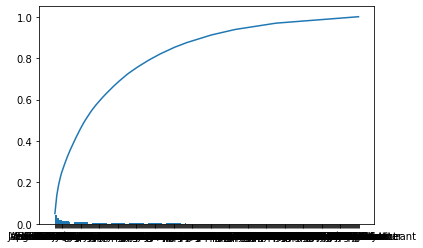

In [10]:
print("Lots of coffee shops!")
print(vacation_venues['Venue Category'].describe(),'\n')
t = vacation_venues['Venue Category'].value_counts(normalize=True)
n = vacation_venues['Venue Category'].value_counts()
print(n.head(10),'\n')
print(t.head(10),'\n')
print(n.tail(10),'\n')
x = t.index.values
h = t.values
c = h.cumsum()
plt.bar(x, h)
plt.plot(x, c)

In [11]:
# derive features with one hot encoding
vacation_onehot = pd.get_dummies(vacation_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
vacation_onehot['Name'] = vacation_venues['Name'] 

# move postal code column to the first column
fixed_columns = [vacation_onehot.columns[-1]] + list(vacation_onehot.columns[:-1])
vacation_onehot = vacation_onehot[fixed_columns]

name_counts = vacation_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
print(name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]),'\n')
vacation_hot_counts = vacation_onehot.merge(name_counts, on='Name')

print(vacation_hot_counts.shape,'\n')
print('Some locations only have a few venues.')
print('Some have up to 100.')

       Count
0.00    1.00
0.05    5.30
0.10    8.80
0.25   29.50
0.33   40.18
0.50   60.00
0.67   94.00
0.75  100.00
0.90  100.00
0.95  100.00
1.00  100.00 

(2794, 323) 

Some locations only have a few venues.
Some have up to 100.


In [12]:
# look for locations with few venues
mask = name_counts['Count'] < 10
name_counts[mask].sort_values('Count')

,Name,Count
46,"Mountain Top, Mentone, Alabama, USA",1
45,"Tybee Island, Savannah, Georgia, USA",4
44,"Cinco Bayou, Fort Walton Beach, Florida, USA",5
43,"PCB, Panama City Beach, Florida, USA",6
42,"Little River, Little River, California, USA",7


In [13]:
# group by postal code and take mean by venue type
vacation_grouped = vacation_hot_counts.groupby('Name').mean().reset_index()
print(vacation_grouped.shape)
vacation_grouped.head()

(47, 323)


,Name,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Water Park,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Count
0,"Alexandra Park, Toronto, Ontario, Canada",0.0,0.0,0.01,0.0,0.0,0.01,0.02,0.020000,0.000000,...,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.020000,0.00,100
1,"Asakusa, Taitō, Tokyo, Japan",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.010000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.03,100
2,"Casa Loma, Toronto, Ontario, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.035714,0.00,28
3,"Chinatown, Montreal, Quebec, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.022222,0.022222,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,90
4,"Chinatown, Toronto, Ontario, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.019608,0.000000,...,0.0,0.0,0.019608,0.0,0.0,0.0,0.0,0.000000,0.00,51


In [14]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
X = np.nan_to_num(X)
pca_dataset = StandardScaler().fit_transform(X)

           0    cumsum
0   0.062843  0.062843
1   0.047890  0.110733
2   0.046288  0.157021
3   0.044007  0.201028
4   0.042439  0.243467
5   0.039573  0.283040
6   0.037568  0.320608
7   0.036349  0.356957
8   0.035823  0.392780
9   0.034363  0.427143
10  0.032646  0.459789
11  0.032305  0.492094
12  0.030596  0.522691
13  0.030121  0.552812
14  0.029764  0.582576
15  0.029052  0.611628
16  0.027459  0.639087
17  0.027011  0.666098
18  0.026821  0.692919
19  0.024871  0.717791
20  0.024145  0.741936
21  0.023346  0.765281
22  0.022829  0.788110
23  0.022489  0.810600
24  0.020579  0.831178 

                                       Name         0         1
0  Alexandra Park, Toronto, Ontario, Canada  0.026095 -0.015331
1              Asakusa, Taitō, Tokyo, Japan -0.046104  0.015873
2       Casa Loma, Toronto, Ontario, Canada -0.001228 -0.044556
3       Chinatown, Montreal, Quebec, Canada  0.007765 -0.021182
4       Chinatown, Toronto, Ontario, Canada  0.045961  0.015146 



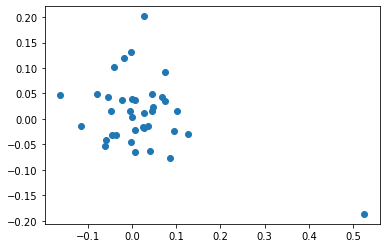

In [15]:
pca = PCA()
pca.fit(pca_dataset)
pca_comps = pd.DataFrame(pca.components_)
pca_comps['Name'] = vacation_grouped['Name'] 
pca_plot = pca_comps.iloc[:, [-1, 0, 1]]
pca_var = pd.DataFrame(pca.explained_variance_ratio_)
pca_var['cumsum'] = pca.explained_variance_ratio_.cumsum()
print(pca_var.head(25),'\n')
print(pca_comps.iloc[0:5, [-1, 0, 1]],'\n')
plt.scatter(pca_plot[0], pca_plot[1])

In [16]:
# determine best number of clusters
vacation_grouped_clustering = pca_comps.iloc[:, 0:25]
#vacation_grouped_clustering = pca_comps.iloc[:, 0:50]
#vacation_grouped_clustering = pca_comps.drop('Name',1)
#vacation_grouped_clustering = pca_dataset
sil = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(vacation_grouped_clustering)
    sil.append([silhouette_score(vacation_grouped_clustering, kmeans.labels_)])
    print("K: ",k)
    print("Clusters:")
    # check cluster labels generated for each row in the dataframe
    print(pd.DataFrame(kmeans.labels_).value_counts())
    # Calculate silhouette_score
    print("Silhouette: ",silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")
    
np.mean(sil)

K:  2
Clusters:
0    36
1     1
dtype: int64
Silhouette:  0.5618651715426699 

K:  3
Clusters:
1    26
0    10
2     1
dtype: int64
Silhouette:  0.0640933004615817 

K:  4
Clusters:
1    17
3    11
2     8
0     1
dtype: int64
Silhouette:  0.05764550054850828 

K:  5
Clusters:
1    16
3    11
2     5
4     4
0     1
dtype: int64
Silhouette:  0.043926545888185745 

K:  6
Clusters:
3    11
4    10
1     9
5     3
0     3
2     1
dtype: int64
Silhouette:  0.04996464718707143 

K:  7
Clusters:
3    8
2    8
6    7
4    6
1    5
5    2
0    1
dtype: int64
Silhouette:  0.045165604613920045 

K:  8
Clusters:
5    12
1     8
7     5
4     4
3     3
0     3
6     1
2     1
dtype: int64
Silhouette:  0.05071614285314083 

K:  9
Clusters:
3    11
1     8
4     5
5     4
0     4
7     2
8     1
6     1
2     1
dtype: int64
Silhouette:  0.04873140812583895 

K:  10
Clusters:
1    7
0    7
9    6
8    4
4    4
7    3
5    2
3    2
6    1
2    1
dtype: int64
Silhouette:  0.0348188720763633 

K:  11
Cl

0.08905255028398842

In [17]:
kmeans = KMeans(n_clusters=7).fit(vacation_grouped_clustering)
print(pd.DataFrame(kmeans.labels_).value_counts())
print("Silhouette: ", silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")

1    11
4     7
6     6
5     5
3     5
0     2
2     1
dtype: int64
Silhouette:  0.07419561502613883 



In [18]:
# import seattle data
seattle = pd.read_csv('./data/seattle_geo.csv')
seattle['Name'] = seattle[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(seattle.columns)
print(seattle.shape)
seattle

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(17, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Downtown,Seattle,Washington,USA,47.607581,-122.336146,"Downtown, Seattle, Washington, USA"
1,West Seattle,Seattle,Washington,USA,47.566933,-122.387116,"West Seattle, Seattle, Washington, USA"
2,Capitol Hill,Seattle,Washington,USA,47.625067,-122.321201,"Capitol Hill, Seattle, Washington, USA"
3,Ballard,Seattle,Washington,USA,47.677038,-122.386494,"Ballard, Seattle, Washington, USA"
4,Queen Anne,Seattle,Washington,USA,47.632492,-122.357077,"Queen Anne, Seattle, Washington, USA"
5,Fremont,Seattle,Washington,USA,47.652553,-122.351225,"Fremont, Seattle, Washington, USA"
6,Lake City,Seattle,Washington,USA,47.719583,-122.295993,"Lake City, Seattle, Washington, USA"
7,Chinatown-International,Seattle,Washington,USA,47.598462,-122.324432,"Chinatown-International, Seattle, Washington, USA"
8,Seattle Waterfront,Seattle,Washington,USA,47.609077,-122.342501,"Seattle Waterfront, Seattle, Washington, USA"
9,Belltown,Seattle,Washington,USA,47.615344,-122.345397,"Belltown, Seattle, Washington, USA"


In [19]:
# visualize Seattle neighborhoods
latitude = seattle.lat.mean()
longitude = (seattle.lon.max() + seattle.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(seattle['lat'], 
                          seattle['lon'],
                          seattle['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [20]:
# process the seattle data
seattle_venues = getNearbyVenues(names=seattle['Name'],
                                 latitudes=seattle['lat'],
                                 longitudes=seattle['lon']
                                )
print("All done!")

All done!


In [21]:
print(seattle_venues.shape)
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))
seattle_venues.head()

(928, 7)
There are 220 uniques categories.


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Benaroya Hall,47.607957,-122.336456,Concert Hall
1,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Seattle Art Museum,47.607052,-122.337819,Art Museum
2,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,The Capital Grille,47.608115,-122.335077,American Restaurant
3,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Gelatiamo,47.608754,-122.336992,Dessert Shop
4,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Starbucks Reserve Bar,47.607027,-122.338199,Coffee Shop


In [22]:
# derive features with one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
seattle_onehot['Name'] = seattle_venues['Name'] 

# move postal code column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

name_counts = seattle_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
print(name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]),'\n')
seattle_hot_counts = seattle_onehot.merge(name_counts, on='Name')

print(seattle_hot_counts.shape,'\n')
print('Some locations only have a few venues.')
print('Some have up to 100.')

       Count
0.00    6.00
0.05    9.20
0.10   11.20
0.25   34.00
0.33   36.00
0.50   42.00
0.67   74.88
0.75   99.00
0.90  100.00
0.95  100.00
1.00  100.00 

(928, 222) 

Some locations only have a few venues.
Some have up to 100.


In [23]:
# group by postal code and take mean by venue type
seattle_grouped = seattle_hot_counts.groupby('Name').mean().reset_index()
print(seattle_grouped.shape)
seattle_grouped.head()

(17, 222)


,Name,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Count
0,"Ballard, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,10
1,"Beacon Hill, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,6
2,"Belltown, Seattle, Washington, USA",0.0,0.0,0.013158,0.0,0.0,0.0,0.013158,0.0,0.0,...,0.0,0.0,0.013158,0.0,0.000000,0.0,0.0,0.000000,0.0,76
3,"Capitol Hill, Seattle, Washington, USA",0.0,0.0,0.105263,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.026316,0.0,0.0,0.026316,0.0,38
4,"Central District, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,12


In [59]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
x_col = X.columns
X = np.nan_to_num(X)
stnd = StandardScaler().fit(X)
S = seattle_grouped.drop('Name', 1)
S = S.reindex(labels=x_col, axis=1)
S = np.nan_to_num(S)
seattle_stnd = stnd.transform(S)

In [60]:
seattle_pca = pca.transform(seattle_stnd)
seattle_comps = pd.DataFrame(seattle_pca)
seattle_comps['Name'] = seattle_grouped['Name'] 
seattle_comps.iloc[0:5, [-1,0,1]]

,Name,0,1
0,"Ballard, Seattle, Washington, USA",-3.020559,1.581527
1,"Beacon Hill, Seattle, Washington, USA",1.803276,0.545913
2,"Belltown, Seattle, Washington, USA",-1.498561,-0.605265
3,"Capitol Hill, Seattle, Washington, USA",-2.053012,-2.017099
4,"Central District, Seattle, Washington, USA",-1.387298,-5.255470


In [61]:
seattle_grouped_clustering = seattle_comps.iloc[:, 0:25]

In [62]:
S.shape

(17, 322)

In [63]:
seattle_clusters = kmeans.predict(seattle_grouped_clustering)
seattle_clusters[0:5]

array([6, 2, 0, 0, 4])

In [64]:
# add clustering labels
seattle_labeled = seattle_comps.copy()
seattle_labeled.insert(0, 'Cluster Labels', seattle_clusters)
print(seattle_labeled['Cluster Labels'].value_counts())
seattle_labeled.iloc[:, [0,-1]]

4    4
3    4
0    4
6    2
2    2
1    1
Name: Cluster Labels, dtype: int64


,Cluster Labels,Name
0,6,"Ballard, Seattle, Washington, USA"
1,2,"Beacon Hill, Seattle, Washington, USA"
2,0,"Belltown, Seattle, Washington, USA"
3,0,"Capitol Hill, Seattle, Washington, USA"
4,4,"Central District, Seattle, Washington, USA"
5,2,"Chinatown-International, Seattle, Washington, USA"
6,3,"Downtown, Seattle, Washington, USA"
7,0,"Fremont, Seattle, Washington, USA"
8,6,"Georgetown, Seattle, Washington, USA"
9,4,"Lake City, Seattle, Washington, USA"


In [65]:
# add clustering labels
vacation_labeled = pca_comps.copy()
vacation_labeled.insert(0, 'Cluster Labels', kmeans.labels_)
vacation_labeled.head()
combined_labeled = pd.concat([vacation_labeled.iloc[:,[0,-1]], seattle_labeled.iloc[:,[0,-1]]], ignore_index=True)
combined_labeled

,Cluster Labels,Name
0,1,"Alexandra Park, Toronto, Ontario, Canada"
1,5,"Asakusa, Taitō, Tokyo, Japan"
2,5,"Casa Loma, Toronto, Ontario, Canada"
3,1,"Chinatown, Montreal, Quebec, Canada"
4,1,"Chinatown, Toronto, Ontario, Canada"
5,1,"Church and Wellesley, Toronto, Ontario, Canada"
6,6,"Cinco Bayou, Fort Walton Beach, Florida, USA"
7,5,"Destin, Destin, Florida, USA"
8,5,"Distillery District, Toronto, Ontario, Canada"
9,4,"Downtown, Atlanta, Georgia, USA"


In [66]:
seattle_labeled.iloc[:,[0,-1]]

,Cluster Labels,Name
0,6,"Ballard, Seattle, Washington, USA"
1,2,"Beacon Hill, Seattle, Washington, USA"
2,0,"Belltown, Seattle, Washington, USA"
3,0,"Capitol Hill, Seattle, Washington, USA"
4,4,"Central District, Seattle, Washington, USA"
5,2,"Chinatown-International, Seattle, Washington, USA"
6,3,"Downtown, Seattle, Washington, USA"
7,0,"Fremont, Seattle, Washington, USA"
8,6,"Georgetown, Seattle, Washington, USA"
9,4,"Lake City, Seattle, Washington, USA"


In [67]:
combined_labeled['Cluster Labels'].value_counts()

1    12
4    11
3     9
6     8
0     6
5     5
2     3
Name: Cluster Labels, dtype: int64

In [68]:
# cluster 1
print('Cluster 1')
mask0 = combined_labeled['Cluster Labels'] == 1
combined_labeled.loc[mask0, combined_labeled.columns[[0,-1]]]

Cluster 1


,Cluster Labels,Name
0,1,"Alexandra Park, Toronto, Ontario, Canada"
3,1,"Chinatown, Montreal, Quebec, Canada"
4,1,"Chinatown, Toronto, Ontario, Canada"
5,1,"Church and Wellesley, Toronto, Ontario, Canada"
11,1,"Downtown, Gatlinburg, Tennessee, USA"
12,1,"Downtown, Memphis, Tennessee, USA"
14,1,"Downtown, Montreal, Quebec, Canada"
19,1,"Garden District, Toronto, Ontario, Canada"
20,1,"Ginza, Chūō, Tokyo, Japan"
21,1,"Harbourfront, Toronto, Ontario, Canada"


In [70]:
# cluster 4
print('Cluster 4')
mask0 = combined_labeled['Cluster Labels'] == 4
combined_labeled.loc[mask0]

Cluster 4


,Cluster Labels,Name
9,4,"Downtown, Atlanta, Georgia, USA"
10,4,"Downtown, Charleston, South Carolina, USA"
15,4,"Downtown, Ukiah, California, USA"
17,4,"Financial District, Toronto, Ontario, Canada"
23,4,"Highland, Denver, Colorado, USA"
24,4,"Historic District, Savannah, Georgia, USA"
28,4,"Little River, Little River, California, USA"
41,4,"Central District, Seattle, Washington, USA"
46,4,"Lake City, Seattle, Washington, USA"
50,4,"SoDo, Seattle, Washington, USA"


In [71]:
# cluster 3
print('Cluster 3')
mask0 = combined_labeled['Cluster Labels'] == 3
combined_labeled.loc[mask0]

Cluster 3


,Cluster Labels,Name
13,3,"Downtown, Mendocino, California, USA"
25,3,"Kensington Market, Toronto, Ontario, Canada"
26,3,"Lake Kawaguchi, Fujikawaguchiko, Yamanashi, Japan"
29,3,"Lodo, Denver, Colorado, USA"
32,3,"Mile End, Montreal, Quebec, Canada"
43,3,"Downtown, Seattle, Washington, USA"
47,3,"Pioneer Square, Seattle, Washington, USA"
49,3,"Seattle Waterfront, Seattle, Washington, USA"
52,3,"Wallingford, Seattle, Washington, USA"


In [72]:
# cluster 6
print('Cluster 6')
mask0 = combined_labeled['Cluster Labels'] == 6
combined_labeled.loc[mask0]

Cluster 6


,Cluster Labels,Name
6,6,"Cinco Bayou, Fort Walton Beach, Florida, USA"
16,6,"Entertainment District, Toronto, Ontario, Canada"
18,6,"French Quarter, New Orleans, Louisiana, USA"
22,6,"Higashiyama, Kyoto, Kyoto, Japan"
33,6,"Minami, Osaka, Osaka, Japan"
35,6,"Nara Park, Nara, Nara, Japan"
37,6,"Ballard, Seattle, Washington, USA"
45,6,"Georgetown, Seattle, Washington, USA"


In [73]:
# cluster 0
print('Cluster 0')
mask0 = combined_labeled['Cluster Labels'] == 0
combined_labeled.loc[mask0]

Cluster 0


,Cluster Labels,Name
31,0,"Midtown, Atlanta, Georgia, USA"
34,0,"Mountain Top, Mentone, Alabama, USA"
39,0,"Belltown, Seattle, Washington, USA"
40,0,"Capitol Hill, Seattle, Washington, USA"
44,0,"Fremont, Seattle, Washington, USA"
48,0,"Queen Anne, Seattle, Washington, USA"


In [74]:
# cluster 5
print('Cluster 5')
mask0 = combined_labeled['Cluster Labels'] == 5
combined_labeled.loc[mask0]

Cluster 5


,Cluster Labels,Name
1,5,"Asakusa, Taitō, Tokyo, Japan"
2,5,"Casa Loma, Toronto, Ontario, Canada"
7,5,"Destin, Destin, Florida, USA"
8,5,"Distillery District, Toronto, Ontario, Canada"
30,5,"Manitou Springs, Manitou Springs, Colorado, USA"


In [75]:
# cluster 2
print('Cluster 2')
mask0 = combined_labeled['Cluster Labels'] == 2
combined_labeled.loc[mask0]

Cluster 2


,Cluster Labels,Name
36,2,"Old Montreal, Montreal, Quebec, Canada"
38,2,"Beacon Hill, Seattle, Washington, USA"
42,2,"Chinatown-International, Seattle, Washington, USA"


In [42]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html